In [125]:
import tensorflow as tf

In [126]:
from tensorflow import keras

In [127]:
import numpy as np
import pandas as pd 
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [128]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [129]:
import torch
import fastai
from fastai import *

from fastai.vision import *

In [130]:
fastai.__version__

'1.0.61'

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [132]:
import warnings
warnings.filterwarnings('ignore')

from numpy.random import seed
seed(3000)

In [133]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms

In [134]:
print(os.listdir("../AV Hack"))

['.ipynb_checkpoints', '01_LeNet5 Architecture.ipynb', '02_AlexNet Architecture.ipynb', '03_VGG_16_Architecture.ipynb', '04_VGG-16 Transfer Learning.ipynb', '12. Transfer Learning using TF Keras.ipynb', '13. Transfer_learning_pytorch.ipynb', '490_506670_cf_Ankit_AV_ship_detection_9_june.ipynb', 'data', 'Hack.ipynb', 'Hack_final.ipynb', 'model.hdf5', 'models', 'retry.csv', 'sample_ZlBsYYp.csv', 'submission.csv', 'test_3w1q66B.csv', 'train']


In [135]:
## set the data folder
data_folder = Path("../AV Hack")
# define the path for loading .jpg images
data_path = "../AV Hack/train/images"
path = os.path.join(data_path , "*jpg")
train_files = pd.read_csv('../AV Hack/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('../AV Hack/test_3w1q66B.csv')

In [136]:
train_files.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [137]:
test_files.head()


,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


## Loading Images

In [138]:
def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(data_path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(data_path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [139]:
# Load Train and Test
X_train = load()
test = load('test')


100%|█████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:03<00:00, 718.22it/s]


In [140]:
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'test shape: {test.shape}')

train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


In [141]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

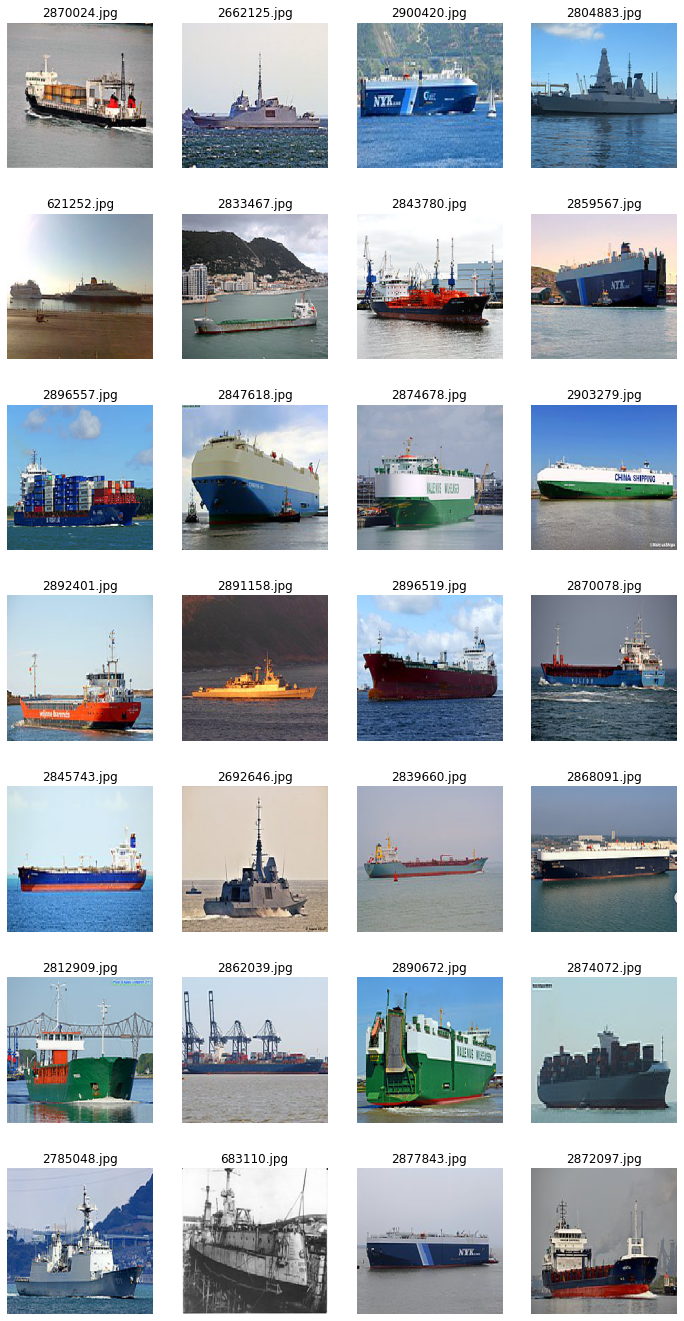

60257

In [142]:
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["image"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

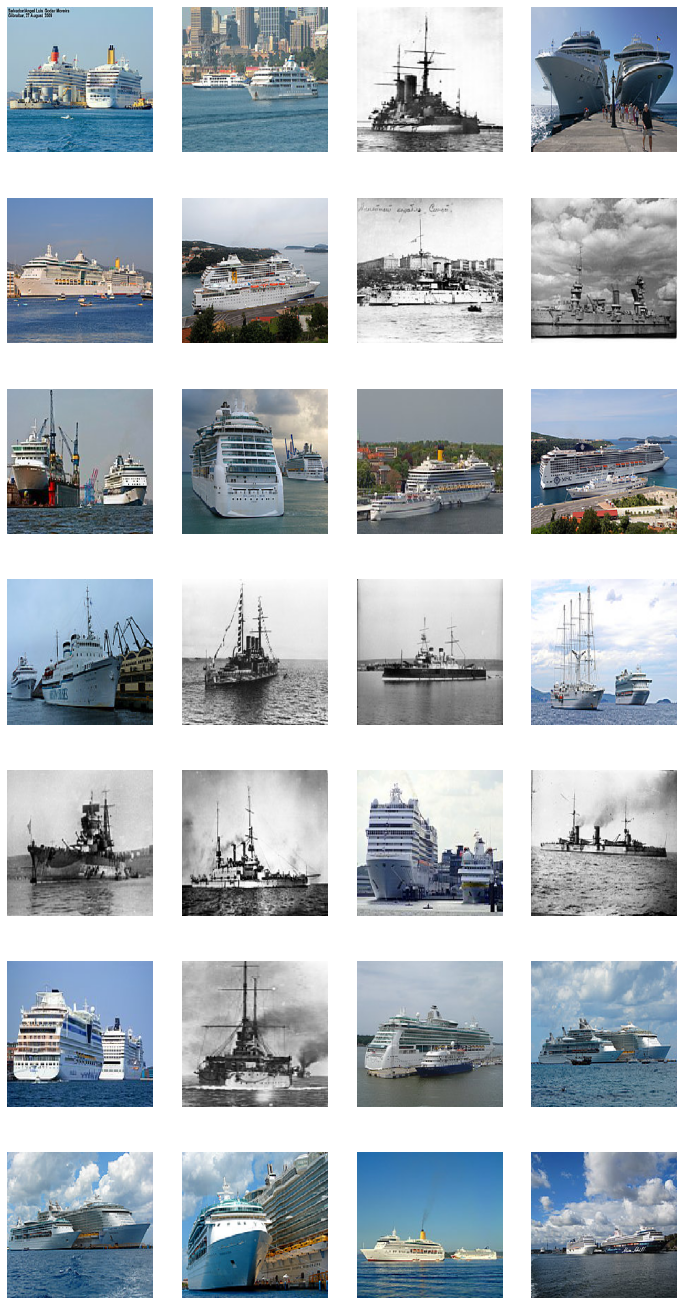

60258

In [143]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test
gc.collect()

## EDA

<AxesSubplot:xlabel='category', ylabel='count'>

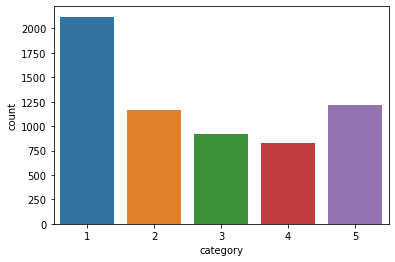

In [144]:
sns.countplot(x='category' , data=train_files)

In [145]:
train_files['category'].value_counts(normalize=False)

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [146]:
def plot_class(cat):
    
    fetch = train_files.loc[train_files['category']==cat][:3]
    fig = plt.figure(figsize=(20,15))
    
    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,3 ,i)
        plt.imshow(train_images[index])
        #plt.xlabel(cat + " (Index:" +str(index)+")" )
    plt.show()

## F1 Score Generator and Printer

In [147]:
class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

## Xception

In [148]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [149]:
model = Xception(include_top=False, input_shape=(224,224,3))

In [150]:
x = GlobalAveragePooling2D()(model.output)
#x = Dense(6, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)
model.save('model.hdf5')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=3000,
                                                    test_size=0.2)

In [152]:
print(x_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()

(5001, 224, 224, 3)
(1251, 224, 224, 3)
(5001, 5)
(1251, 5)


11938

In [153]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=Adam(lr=0.0001))

datagen = ImageDataGenerator(rotation_range=45, horizontal_flip=True, width_shift_range=0.5, height_shift_range=0.5,dtype='float32')

#datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train, y_train,batch_size=batch_size)
#valgen=ImageDataGenerator(horizontal_flip=False)
#val_generator=valgen.flow(X_val,y_val,batch_size=batch_size,seed=1)

f1 = printf1(X_train, y_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [ ]:
history = model.fit(train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              
                              epochs=10)

In [158]:
X_test=load('test')

100%|█████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:02<00:00, 980.62it/s]


In [159]:
X_test.shape

(2680, 224, 224, 3)

In [160]:
pred = np.argmax(model.predict(X_test), axis=1)

NameError: name 'y_val' is not defined

In [161]:
pred

array([3, 3, 3, 1, ..., 3, 3, 3, 3], dtype=int64)

In [163]:
sub = pd.read_csv("sample_ZlBsYYp.csv")
sub['category']=pred+1
sub.to_csv('sub_3.csv',index=False)
sub.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


## Efficient Net 

In [164]:
from efficientnet_pytorch import EfficientNet

In [165]:
from torchvision import datasets

In [170]:
from fastai.callbacks import *

In [171]:
data_eff = ImageDataBunch.from_df(df=train_files, path=data_folder/'train', folder = 'images',
                                 bs=32,size=299,valid_pct=0.1,resize_method=ResizeMethod.SQUISH,
                                 ds_tfms=get_transforms(max_lighting=0.2, max_zoom=1.2,
                                                        max_warp=0.2, max_rotate=10,
                                                        xtra_tfms=[flip_lr()]))
test_data =ImageList.from_df(test_files, path=data_folder/'train', folder='images')
data=data_eff.add(test_data)
#data.normalize(imagenet_stats)

In [172]:
from efficientnet_pytorch import EfficientNet
model_eff = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [173]:
model_eff._fc=nn.Linear(model_eff._fc.in_features, data.c)

In [177]:
learn_eff = cnn_learner(data_eff, model_eff,
                   [FBeta()])

AttributeError: 'bool' object has no attribute 'dim'

In [175]:
learn_eff.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [179]:
learn = cnn_learner(data=data_eff, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

In [181]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (8307 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,2,3,2
Path: ..\AV Hack\train;

Valid: LabelList (625 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
2,2,1,4,5
Path: ..\AV Hack\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
#lets start with steepset slope point. adding wd (weight decay) not to overfit as we are running 15 epochs 
lr = 3e-03
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
